# Predicting Gold Prices Using Custom RBF Neural Network

### Project Overview

This project aims to predict gold prices using a radial basis function (RBF) neural network applied to time series data. After collecting historical gold price data, preprocessing steps involve handling missing values, normalization, and splitting the dataset. The RBF network, implemented via provided code, is trained on the prepared data, with model performance evaluated using metrics like Mean Squared Error (MSE). Deployment involves making predictions on new data while monitoring and updating the model over time for continuous improvement, potentially incorporating additional features and exploring different algorithms for enhanced accuracy.

### Import Libraries

In [1]:
# Utilities
import numpy as np
import pandas as pd

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Deep Learning
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, History
from keras.initializers import Initializer
import tensorflow.keras.backend as K

# Visualization
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "svg" # static plotly
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

2024-03-14 16:46:29.521891: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Dataset Input

Here's what each column represents:
* Period: This column indicates the period or time interval during which the gold price was recorded. It is represented by integers.
* Gold Price: This column contains the price of gold during the corresponding period. It is represented by floating-point numbers.

The dataset contains 1566 entries and consists of two columns: "Period" and "Gold Price". There are no missing values in either column, as indicated by the "Non-Null Count" for both columns.

In [2]:
df = pd.read_excel('./emazzy.xlsx')

In [3]:
df.head()

,Period,Gold Price
0,1,1223.8
1,2,1237.5
2,3,1243.8
3,4,1258.0
4,5,1260.9


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1566 entries, 0 to 1565
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Period      1566 non-null   int64  
 1   Gold Price  1566 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 24.6 KB


### Custom RBF Layer

This code defines a custom layer called RBFLayer, which inherits from the Dense layer in TensorFlow/Keras. It implements a Radial Basis Function (RBF) layer for use in neural networks. In the initialization method, it takes parameters like units, initializer, and betas (which control the width of the RBFs). In the build method, it constructs the layer's weights, specifically the centers of the RBFs, and ensures they are trainable. The call method computes the activations of the RBFs based on the input data and the RBF centers, using the Gaussian radial basis function formula. This layer can be used as a part of a neural network architecture for various tasks such as function approximation or classification.

In [5]:
# Define RBFLayer class
class RBFLayer(Dense):
    def __init__(self, units, initializer=None, betas=1.0, **kwargs):
        super(RBFLayer, self).__init__(units, **kwargs)
        self.betas = betas
        self.initializer = initializer

    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]

        if self.initializer is not None:
            self.centers = self.add_weight(name='centers',
                                           shape=(self.units, input_dim),
                                           initializer=self.initializer,
                                           trainable=True)
        else:
            self.centers = self.add_weight(name='centers',
                                           shape=(self.units, input_dim),
                                           initializer='uniform',
                                           trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        c = self.centers
        x = inputs[:, None]
        distances = K.sum(K.square(x - c), axis=-1)
        output = K.exp(-self.betas * distances)
        return output

In [6]:
# Custom initializer for initializing centers randomly
class InitCentersRandom(Initializer):
    def __init__(self, X):
        self.X = X

    def __call__(self, shape, dtype=None):
        assert shape[1:] == self.X.shape[1:]
        idx = np.random.choice(self.X.shape[0], shape[0], replace=False)
        return self.X[idx, :]

### Preparing for Training

In [7]:
X = df[['Period']].values
y = df['Gold Price'].values
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

### Build Neural Network Model

In [9]:
# Build RBF neural network model
model = Sequential([
    RBFLayer(1, initializer=InitCentersRandom(X_train), betas=2.0, input_shape=(1,)),
    Dense(100, activation='relu'),
    Dropout(0.3),
    Dense(1)
])

The provided model is a Sequential neural network architecture consisting of three layers. The first layer is a custom RBFLayer with one unit, initialized with random centers based on the training data X_train, and a beta parameter set to 2.0, representing the width of the radial basis functions. This layer serves as a radial basis function transformation. The second layer is a Dense layer with 100 units and ReLU activation function, followed by a Dropout layer with a dropout rate of 0.3 to prevent overfitting. Finally, there's another Dense layer with one unit, which serves as the output layer. This model is designed for regression tasks, where it learns to predict a continuous output based on the input features.

In [10]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [12]:
history = model.fit(X_train, y_train, batch_size=16, epochs=500, callbacks=[early_stopping], validation_split=0.2)

Epoch 1/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0925 - val_loss: 0.0406
Epoch 2/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0418 - val_loss: 0.0298
Epoch 3/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0293 - val_loss: 0.0220
Epoch 4/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0249 - val_loss: 0.0179
Epoch 5/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0206 - val_loss: 0.0163
Epoch 6/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0171 - val_loss: 0.0144
Epoch 7/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0180 - val_loss: 0.0132
Epoch 8/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0145 - val_loss: 0.0122
Epoch 9/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0139 - val_loss: 0.0115
Epoch 10/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0137 - val_loss: 0.0112
Epoch 11/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0136 - val_loss: 0.0110
Epoch 12/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0

This log represents the training process of a neural network model across multiple epochs. Each epoch corresponds to a complete pass through the training data. During training, the model aims to minimize a loss function, which measures the discrepancy between predicted and actual values. In this log, "loss" refers to the value of this loss function on the training data, while "val_loss" refers to the loss on a separate validation dataset. The goal is to achieve low values for both losses, indicating good performance and generalization of the model. The log also provides information about the time taken for each epoch (in seconds) and the loss values achieved. The decreasing trend of both training and validation losses suggests that the model is learning and improving over successive epochs.

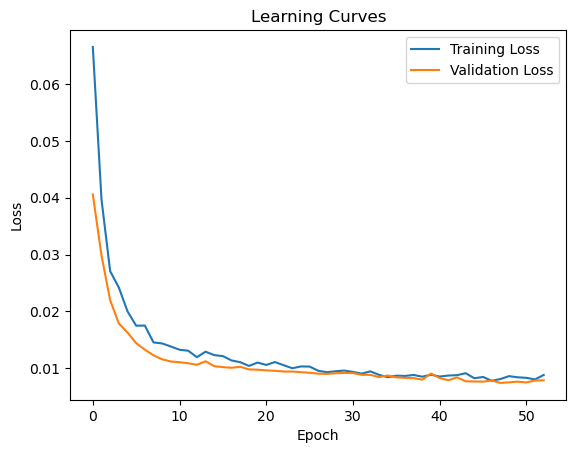

In [13]:
# Plot learning curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Evaluation

In [14]:
# Evaluate the model
mse = model.evaluate(X_test, y_test)

# Make predictions
predictions = model.predict(X_test)
predictions = scaler_y.inverse_transform(predictions)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


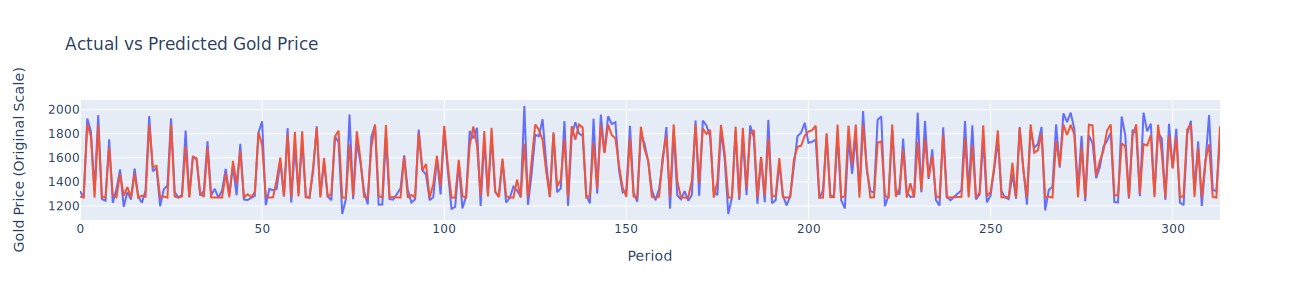

In [15]:
# Invert the scaled y_test values back to original scale using scaler_y
y_test_original = scaler_y.inverse_transform(y_test)

# Convert predictions and actual values to DataFrame for easier manipulation
results_df = pd.DataFrame({'Actual': y_test_original.flatten(), 'Predicted': predictions.flatten()})

# Create a scatter plot
fig = go.Figure()

fig.add_trace(go.Scatter(x=results_df.index, y=results_df['Actual'], mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=results_df.index, y=results_df['Predicted'], mode='lines', name='Predicted'))

fig.update_layout(title='Actual vs Predicted Gold Price',
                  xaxis_title='Period',
                  yaxis_title='Gold Price (Original Scale)',
                  legend=dict(x=0, y=1, traceorder='normal'))

fig.update_layout(height=300, width=1300, showlegend=False)

fig.show()


In [16]:
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.00706853112205863


### Conclusion

MSE value of approximately 0.007 suggests that, on average, the squared difference between the predicted and actual values is very small, indicating that the model performs well in predicting the target variable.